In [1]:
import numpy as np
import pandas as pdn
import matplotlib.pyplot as plt
import os
import random as r
#updateed vers

In [2]:
X_train, X_test = np.loadtxt('X_train.csv'), np.loadtxt('X_test.csv')
y_train, y_test = np.loadtxt('Y_train.csv'), np.loadtxt('Y_test.csv')

In [3]:
X_train.shape

(100, 2)

In [4]:
y_train[:5]

array([-40.22844192, 121.19952851, 144.96172544, -53.60851723,
       -80.78260693])

In [5]:
def initialize_network(n_inputs, n_hidden, n_outputs=1):
    network = list()
    hidden_layer = [{'weights':[r.random() for _ in range(n_inputs+1)]} for _ in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[r.random() for _ in range(n_hidden+1)]} for _ in range(n_outputs)]
    network.append(output_layer)
    return network

hidden layer: list comprehension that for each neuron, creates a dictionary of weights. EX: [{weights: 0.4, 0.3, 0.4}, {weights: 0.7, 0.1, 0.2}...] for each neuron.
number of weights matches the number of inputs+1, and creates neuron with number that is equal to n_hidden+1.
They are all + 1 to account for a bias. 
output_layer is similar, but number of weights is same as number of neurons created in the hidden layer, and the number of neurons is the number specified for the number of outputs being created. 

In [7]:
from random import seed
r.seed(2)
ntwrk = initialize_network(2, 5, 1)
for layer in ntwrk:
    print(layer)

[{'weights': [0.9560342718892494, 0.9478274870593494, 0.05655136772680869]}, {'weights': [0.08487199515892163, 0.8354988781294496, 0.7359699890685233]}, {'weights': [0.6697304014402209, 0.3081364575891442, 0.6059441656784624]}, {'weights': [0.6068017336408379, 0.5812040171120031, 0.15838287025480557]}, {'weights': [0.43066964029126864, 0.39353182020537136, 0.7230120812374659]}]
[{'weights': [0.9948195629497427, 0.9493954730932436, 0.5441770474293208, 0.4448541887258536, 0.2682407416493281, 0.03592432939285761]}]


In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def activate(weights, inputs):
    bias = weights[-1]
    activation = 0
    for i in range(len(weights)-1):
        activation += inputs[i] * weights[i]
    return activation + bias

In [9]:
def forward_propagate(network, row):
    inputs = row
    for layer_id, layer in enumerate(network):
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            if layer_id == 0:  
                neuron['output'] = sigmoid(activation)
            else:
                neuron['output'] = activation
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [10]:
outputs = [forward_propagate(ntwrk, row)[0] for row in X_train]
print(outputs)

[1.541266176500034, 2.586933980013877, 2.86904937725447, 1.8627850820412455, 0.8255045081051218, 2.740996953478532, 2.3075839030440344, 1.764074658561769, 2.1989074248013347, 1.4880323726741107, 1.3993904982929046, 1.9578662135810871, 2.661927812211707, 1.1111543710573608, 2.9140828959736065, 1.7406869863250631, 1.9856910516023496, 1.6415556946235554, 1.598392004119972, 2.6123439907469583, 2.371725287030742, 2.1243457515468007, 1.4847131478493383, 2.5579166601486234, 2.0527505970840494, 1.6960593343947652, 2.446582354287561, 2.6640101349499163, 2.4299381509493294, 2.914223569721876, 1.4761463761030869, 1.9545032578976738, 1.5220036629942193, 2.389076455990158, 0.8700811362000658, 2.346543638775466, 2.365746470696657, 2.8212825830711155, 0.7531870413362907, 2.213570745566873, 2.722041730623013, 1.9243946893889645, 1.4595900973584235, 0.9314965995663164, 2.102198264017661, 2.206961224886205, 2.1293394967445107, 0.7108321859135307, 2.253213716630556, 2.108168254587788, 2.32375054468383, 0

In [11]:
def sig_derivative(output):
    output = np.clip(output, -500, 500)
    return output * (1.0 - output)

def error(actual, predicted):
    return (actual - predicted) ** 2

In [12]:
def backward_propagate(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        #if the layer being worked on is not the output layer:
        if i != len(network) - 1:
            #each layer has neurons, and each neuron is now a dict of 'weights', 'output', and 'delta'
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += neuron['weights'][j] * neuron['delta']
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                #derivative of MSE
                errors.append(neuron['output'] - expected)
        for j in range(len(layer)):
            neuron = layer[j]
            if i == len(network) - 1:
                neuron['delta'] = errors[j]
            else:
                neuron['delta'] = errors[j] * sig_derivative(neuron['output'])

In [13]:
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i-1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] -= l_rate * neuron['delta']

In [14]:
def epoch_breaker(n_epoch):
    i=0
    interval = max(1, n_epoch // 30)
    nums = list(range(0, n_epoch, interval))
    nums.append(n_epoch)
    return nums

In [15]:
def train_network(network, X_train, y_train, l_rate, n_epoch, should_print=True):
    nums = epoch_breaker(n_epoch)
    loss = []
    for epoch in range(n_epoch):
        sum_error = 0
        for row,target in zip(X_train, y_train):
            outputs = forward_propagate(network, row)
            expected = target
            sum_error += (expected-outputs[0])**2
            backward_propagate(network, expected)
            update_weights(network, row, l_rate)
        avg_error = sum_error / len(X_train)
        loss.append(avg_error)
        if epoch in nums and should_print:
             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, avg_error))
    return loss

In [16]:
r.seed(2)
epochs = 950

X_train_normalized = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
y_train_normalized = (y_train - y_train.mean()) / y_train.std()
X_test_normalized = (X_test - X_test.mean(axis=0)) / X_train.std(axis=0)
loss = train_network(ntwrk, X_train_normalized, y_train_normalized, 0.01, epochs)

>epoch=0, lrate=0.010, error=1.172
>epoch=31, lrate=0.010, error=0.020
>epoch=62, lrate=0.010, error=0.014
>epoch=93, lrate=0.010, error=0.011
>epoch=124, lrate=0.010, error=0.008
>epoch=155, lrate=0.010, error=0.007
>epoch=186, lrate=0.010, error=0.005
>epoch=217, lrate=0.010, error=0.005
>epoch=248, lrate=0.010, error=0.004
>epoch=279, lrate=0.010, error=0.004
>epoch=310, lrate=0.010, error=0.003
>epoch=341, lrate=0.010, error=0.003
>epoch=372, lrate=0.010, error=0.003
>epoch=403, lrate=0.010, error=0.003
>epoch=434, lrate=0.010, error=0.002
>epoch=465, lrate=0.010, error=0.002
>epoch=496, lrate=0.010, error=0.002
>epoch=527, lrate=0.010, error=0.002
>epoch=558, lrate=0.010, error=0.002
>epoch=589, lrate=0.010, error=0.002
>epoch=620, lrate=0.010, error=0.002
>epoch=651, lrate=0.010, error=0.002
>epoch=682, lrate=0.010, error=0.002
>epoch=713, lrate=0.010, error=0.002
>epoch=744, lrate=0.010, error=0.002
>epoch=775, lrate=0.010, error=0.001
>epoch=806, lrate=0.010, error=0.001
>epoch

In [17]:
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs[0]

In [18]:
def compute_metrics(y_true, y_pred, dataset_name):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    print(f"{dataset_name} Metrics:")
    print(f"  MSE: {mse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R² Score: {r2:.3f}")

In [19]:
train_pred_norm = [predict(ntwrk, row) for row in X_train_normalized]
train_pred = np.array([p * y_train.std() + y_train.mean() for p in train_pred_norm])

predictions_norm = [predict(ntwrk, row) for row in X_test_normalized]

preds_final = []
for p in predictions_norm:
    predicted_y = p * y_train.std() + y_train.mean()
    preds_final.append(predicted_y)

mse = np.mean((np.array(preds_final) - y_test) ** 2)

print("Test MSE:", mse)

Test MSE: 29.41930946016461


In [20]:
compute_metrics(y_train, train_pred, "Training")
compute_metrics(y_test, preds_final, "Test")

Training Metrics:
  MSE: 6.768
  MAE: 2.100
  R² Score: 0.999
Test Metrics:
  MSE: 29.419
  MAE: 4.186
  R² Score: 0.995


In [21]:
print(y_train.min(), y_train.max())

-147.078116997524 160.16900121190633


This 2-layer architecture uses the Sigmoid activation function for the hidden layer, and backpropagation for regression using the Mean Square Error (MSE) loss. This is different from the update rule for the network trained for binary classification that uses log loss because tbe binary classifier uses sigmoid in the output, not the hidden layer while the regression output uses no activation. This affects the output because for binary classifier, the output will only be 0 or 1, while using regression can output any real number. 

Questions: 
1.) The activation function being used for the output layer is the linear activation. The dataset, and more specifically the target values, is a continuous set of values in a wide range of possibilities, along with tasking the MSE loss, the problem is related to regression. Since linear allows for predictions of any real value, using other activations would limit the possible predictions.

2.) There should be 1 neuron in the output layer, as we want it to predict one value based on the input. This is hinted based on the target data also being one dimensional.

3.) After playing around with different numbers of neurons, learning rates, and epochs, the lowest training MSE was 6.768 and the lowest test MSE obtained was 29.419. This test data having a higher error shows some overfitting, though with an R^2 score of .995, it is clear the model stll generalizes pretty well with unseen data. 

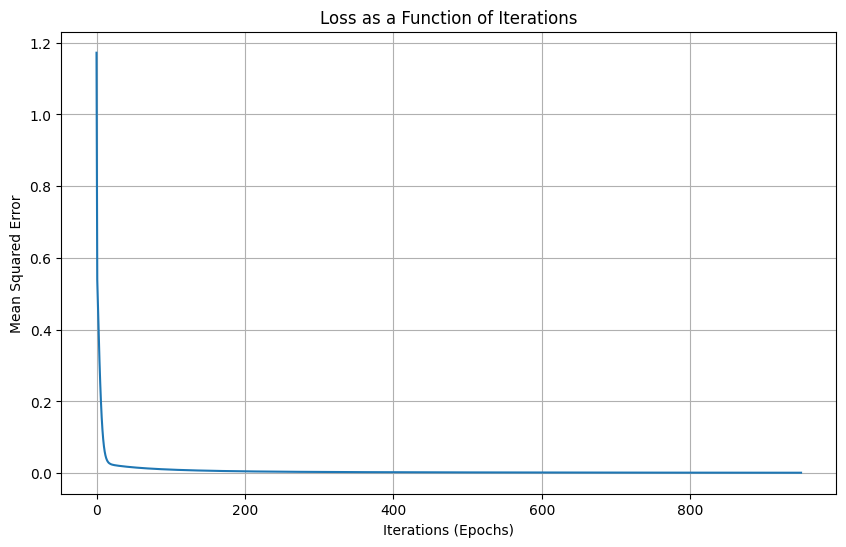

In [24]:
plt.figure(figsize=(10,6))
plt.plot(loss)
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Mean Squared Error')
plt.title('Loss as a Function of Iterations')
plt.grid(True)
plt.show()

In [25]:

lr_nums = np.arange(0.001, 0.01, .0015).tolist()
accuracies = {}

for num in lr_nums:
    losses = train_network(ntwrk, X_train_normalized, y_train_normalized, num, epochs, should_print=False)
    train_pred_norm = [predict(ntwrk, row) for row in X_train_normalized]
    train_pred = np.array([p * y_train.std() + y_train.mean() for p in train_pred_norm])
    
    predictions_norm = [predict(ntwrk, row) for row in X_test_normalized]
    
    preds_final = []
    for p in predictions_norm:
        predicted_y = p * y_train.std() + y_train.mean()
        preds_final.append(predicted_y)
        
    train_mse = np.mean((train_pred - y_train) ** 2)
    test_mse = np.mean((preds_final - y_test) ** 2)
    
    accuracies[num] = {'train_mse': train_mse,
                        'test_mse': test_mse
                      }
    print(f"  Learning Rate: {num}")
    print(f"  Train MSE: {train_mse:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")

  Learning Rate: 0.001
  Train MSE: 6.2520
  Test MSE: 28.5341
  Learning Rate: 0.0025
  Train MSE: 5.2891
  Test MSE: 26.0072
  Learning Rate: 0.004
  Train MSE: 4.2774
  Test MSE: 23.2778
  Learning Rate: 0.0055000000000000005
  Train MSE: 3.4120
  Test MSE: 20.9303
  Learning Rate: 0.007
  Train MSE: 2.7243
  Test MSE: 19.0759
  Learning Rate: 0.0085
  Train MSE: 2.1834
  Test MSE: 17.6308
  Learning Rate: 0.010000000000000002
  Train MSE: 1.7478
  Test MSE: 16.4842


In [26]:
train_mses, test_mses = [], []
learning_rates = list(accuracies.keys())

for lr in learning_rates:
    train_mses.append([accuracies[lr]['train_mse']])
    test_mses.append([accuracies[lr]['test_mse']])

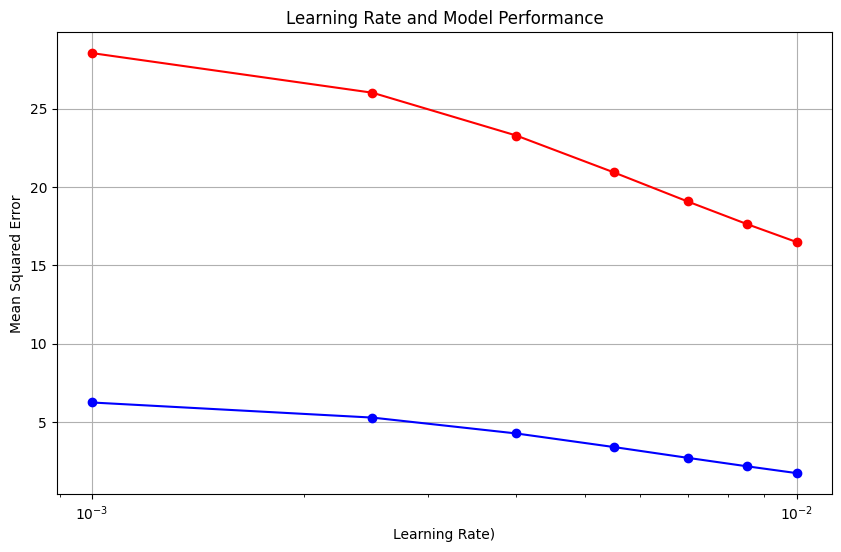

In [27]:
plt.figure(figsize=(10,6))
plt.plot(learning_rates, train_mses, 'o-', color='blue', label='Train MSE')
plt.plot(learning_rates, test_mses, 'o-', color='red', label='Test MSE')
plt.xlabel('Learning Rate)')
plt.ylabel('Mean Squared Error')
plt.title('Learning Rate and Model Performance')
plt.grid(True)
plt.xscale('log')
plt.show()

5.) Learning rate determines how quickly the model will try to adapt to the training data. High ones will cause a large update in its parameters, with a chance of overshooting the minima. On the other hand, smaller learning rates will update with much smaller changes in the parameters, however might not ever reach the minima.